## GBT Model

In [16]:
from pyspark.sql import SparkSession, functions as F, types as T
import unicodedata
from functools import reduce
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Imputer, VectorAssembler
from pyspark.sql.types import DoubleType

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

In [2]:
df = spark.read.parquet("gs://dsa5208-mllib-proj/processed/df_cleaned.parquet")

In [3]:
df.show(10, truncate=False)

+-------+--------+---------+---------+-------+-------+---------+--------+----------+------------+
|tmp_cel|latitude|longitude|elevation|dew_cel|slp_hpa|wnd_speed|vis_dist|cig_height|date_numeric|
+-------+--------+---------+---------+-------+-------+---------+--------+----------+------------+
|7.4    |53.25   |4.9166667|5.0      |5.9    |992.0  |90.0     |13000.0 |780.0     |19723.0     |
|7.9    |53.25   |4.9166667|5.0      |4.9    |992.1  |110.0    |24000.0 |1440.0    |19723.0     |
|7.2    |53.25   |4.9166667|5.0      |5.9    |992.6  |70.0     |18000.0 |900.0     |19723.0     |
|8.1    |53.25   |4.9166667|5.0      |6.2    |992.5  |110.0    |15000.0 |1110.0    |19723.0     |
|7.9    |53.25   |4.9166667|5.0      |6.1    |992.8  |130.0    |6000.0  |1170.0    |19723.0     |
|8.3    |53.25   |4.9166667|5.0      |6.3    |993.0  |120.0    |6000.0  |900.0     |19723.0     |
|7.5    |53.25   |4.9166667|5.0      |5.8    |993.7  |110.0    |10000.0 |690.0     |19723.0     |
|8.2    |53.25   |4.

In [4]:
# Check if all rows imported correctly
df.count()

17953096

In [5]:
spark.sparkContext.setCheckpointDir("gs://dsa5208-mllib-proj/gbt/spark_checkpoints/")

TARGET_COL = "tmp_cel"
FEATURE_COLS = [
    "latitude","longitude","elevation",
    "dew_cel","slp_hpa","wnd_speed","vis_dist","cig_height",
    "date_numeric"]

# Split the dataset into test and training
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# --- stages ---
imp_cols = [f"{c}__imp" for c in FEATURE_COLS]
imputer = Imputer(inputCols=FEATURE_COLS, outputCols=imp_cols, strategy="mean")

va = VectorAssembler(inputCols=imp_cols, outputCol="features")
gbt = GBTRegressor(labelCol=TARGET_COL, featuresCol="features", seed=42)
pipeline = Pipeline(stages=[imputer, va, gbt])

In [6]:
# ---- hyperparameter grid ----

paramGrid = (ParamGridBuilder()
    .addGrid(gbt.maxDepth, [7,9,11])
    .addGrid(gbt.maxIter, [50,60,70])
    .addGrid(gbt.stepSize, [0.05])
    .addGrid(gbt.subsamplingRate, [0.6])
    .addGrid(gbt.minInstancesPerNode, [20])
    .build())

In [7]:
# ---- evaluator for validation ----
evaluator = RegressionEvaluator(labelCol=TARGET_COL, predictionCol="prediction", metricName="rmse")

# ---- validation split (80/20 inside training) ----
tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=1
)

# ---- fit tuned model on TRAIN ----
tuned_model = tvs.fit(train_df)

# best parameters
best_model = tuned_model.bestModel

25/11/05 00:53:35 WARN DAGScheduler: Broadcasting large task binary with size 1017.6 KiB
25/11/05 00:53:35 WARN DAGScheduler: Broadcasting large task binary with size 1027.6 KiB
25/11/05 00:53:37 WARN DAGScheduler: Broadcasting large task binary with size 1023.3 KiB
25/11/05 00:54:38 WARN DAGScheduler: Broadcasting large task binary with size 1002.4 KiB
25/11/05 00:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1010.2 KiB
25/11/05 00:54:41 WARN DAGScheduler: Broadcasting large task binary with size 1005.8 KiB
25/11/05 00:55:43 WARN DAGScheduler: Broadcasting large task binary with size 1001.7 KiB
25/11/05 00:55:44 WARN DAGScheduler: Broadcasting large task binary with size 1009.6 KiB
25/11/05 00:55:45 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB
25/11/05 00:56:48 WARN DAGScheduler: Broadcasting large task binary with size 1007.9 KiB
25/11/05 00:59:10 WARN DAGScheduler: Broadcasting large task binary with size 1023.3 KiB
25/11/05 01:00:13 WAR

25/11/05 01:12:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/05 01:12:44 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/05 01:12:44 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/05 01:12:45 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/05 01:12:46 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/05 01:12:46 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/05 01:12:47 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/05 01:12:48 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:12:49 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:12:49 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/11/05 01:12:50 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/11/05 01:12:51 WARN DAGScheduler: Broadcasting larg

25/11/05 01:14:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/11/05 01:14:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/11/05 01:14:11 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/11/05 01:14:12 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/11/05 01:14:13 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/11/05 01:14:13 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/11/05 01:14:14 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/11/05 01:14:15 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/11/05 01:14:16 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/11/05 01:14:18 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/11/05 01:14:38 WARN DAGScheduler: Broadcasting large task binary with size 1020.3 KiB
25/11/05 01:14:39 WARN DAGScheduler: Broadcasting l

25/11/05 01:16:02 WARN DAGScheduler: Broadcasting large task binary with size 1057.2 KiB
25/11/05 01:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1125.8 KiB
25/11/05 01:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1254.7 KiB
25/11/05 01:16:04 WARN DAGScheduler: Broadcasting large task binary with size 1268.5 KiB
25/11/05 01:16:05 WARN DAGScheduler: Broadcasting large task binary with size 1269.0 KiB
25/11/05 01:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1269.7 KiB
25/11/05 01:16:07 WARN DAGScheduler: Broadcasting large task binary with size 1270.7 KiB
25/11/05 01:16:07 WARN DAGScheduler: Broadcasting large task binary with size 1273.0 KiB
25/11/05 01:16:08 WARN DAGScheduler: Broadcasting large task binary with size 1277.5 KiB
25/11/05 01:16:08 WARN DAGScheduler: Broadcasting large task binary with size 1286.6 KiB
25/11/05 01:16:09 WARN DAGScheduler: Broadcasting large task binary with size 1305.3 KiB
25/11/05 01:16:10 WAR

25/11/05 01:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1272.1 KiB
25/11/05 01:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1306.8 KiB
25/11/05 01:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1371.8 KiB
25/11/05 01:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1485.1 KiB
25/11/05 01:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1484.8 KiB
25/11/05 01:17:36 WARN DAGScheduler: Broadcasting large task binary with size 1485.3 KiB
25/11/05 01:17:36 WARN DAGScheduler: Broadcasting large task binary with size 1486.0 KiB
25/11/05 01:17:37 WARN DAGScheduler: Broadcasting large task binary with size 1487.0 KiB
25/11/05 01:17:38 WARN DAGScheduler: Broadcasting large task binary with size 1489.3 KiB
25/11/05 01:17:38 WARN DAGScheduler: Broadcasting large task binary with size 1493.8 KiB
25/11/05 01:17:39 WARN DAGScheduler: Broadcasting large task binary with size 1502.9 KiB
25/11/05 01:17:39 WAR

25/11/05 01:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1675.7 KiB
25/11/05 01:19:19 WARN DAGScheduler: Broadcasting large task binary with size 1676.2 KiB
25/11/05 01:19:20 WARN DAGScheduler: Broadcasting large task binary with size 1676.9 KiB
25/11/05 01:19:20 WARN DAGScheduler: Broadcasting large task binary with size 1677.9 KiB
25/11/05 01:19:21 WARN DAGScheduler: Broadcasting large task binary with size 1680.2 KiB
25/11/05 01:19:22 WARN DAGScheduler: Broadcasting large task binary with size 1684.7 KiB
25/11/05 01:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1693.8 KiB
25/11/05 01:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1712.5 KiB
25/11/05 01:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1748.8 KiB
25/11/05 01:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1820.3 KiB
25/11/05 01:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1957.5 KiB
25/11/05 01:19:26 WAR

25/11/05 01:20:48 WARN DAGScheduler: Broadcasting large task binary with size 1921.3 KiB
25/11/05 01:20:49 WARN DAGScheduler: Broadcasting large task binary with size 1923.5 KiB
25/11/05 01:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1928.0 KiB
25/11/05 01:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1937.1 KiB
25/11/05 01:20:51 WARN DAGScheduler: Broadcasting large task binary with size 1955.3 KiB
25/11/05 01:20:51 WARN DAGScheduler: Broadcasting large task binary with size 1990.5 KiB
25/11/05 01:20:52 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/11/05 01:20:53 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/05 01:20:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/11/05 01:20:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/11/05 01:20:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/11/05 01:20:57 WARN DAGScheduler:

25/11/05 01:22:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/05 01:22:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/05 01:22:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/05 01:22:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/05 01:22:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/05 01:22:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/11/05 01:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/11/05 01:22:26 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/11/05 01:22:27 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/11/05 01:22:28 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/11/05 01:22:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/11/05 01:22:29 WARN DAGScheduler: Broadcasting larg

25/11/05 01:24:37 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
25/11/05 01:24:38 WARN DAGScheduler: Broadcasting large task binary with size 1022.5 KiB
25/11/05 01:24:38 WARN DAGScheduler: Broadcasting large task binary with size 1056.6 KiB
25/11/05 01:24:39 WARN DAGScheduler: Broadcasting large task binary with size 1119.1 KiB
25/11/05 01:24:40 WARN DAGScheduler: Broadcasting large task binary with size 1231.2 KiB
25/11/05 01:24:41 WARN DAGScheduler: Broadcasting large task binary with size 1235.3 KiB
25/11/05 01:24:42 WARN DAGScheduler: Broadcasting large task binary with size 1235.8 KiB
25/11/05 01:24:42 WARN DAGScheduler: Broadcasting large task binary with size 1236.5 KiB
25/11/05 01:24:43 WARN DAGScheduler: Broadcasting large task binary with size 1237.5 KiB
25/11/05 01:24:43 WARN DAGScheduler: Broadcasting large task binary with size 1239.8 KiB
25/11/05 01:24:44 WARN DAGScheduler: Broadcasting large task binary with size 1244.3 KiB
25/11/05 01:24:45 WAR

25/11/05 01:26:07 WARN DAGScheduler: Broadcasting large task binary with size 1242.9 KiB
25/11/05 01:26:08 WARN DAGScheduler: Broadcasting large task binary with size 1305.8 KiB
25/11/05 01:26:08 WARN DAGScheduler: Broadcasting large task binary with size 1417.7 KiB
25/11/05 01:26:09 WARN DAGScheduler: Broadcasting large task binary with size 1420.6 KiB
25/11/05 01:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1421.1 KiB
25/11/05 01:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1421.8 KiB
25/11/05 01:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1422.8 KiB
25/11/05 01:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1425.0 KiB
25/11/05 01:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1429.6 KiB
25/11/05 01:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1438.7 KiB
25/11/05 01:26:14 WARN DAGScheduler: Broadcasting large task binary with size 1457.4 KiB
25/11/05 01:26:14 WAR

25/11/05 01:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1676.2 KiB
25/11/05 01:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1676.9 KiB
25/11/05 01:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1677.9 KiB
25/11/05 01:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1680.2 KiB
25/11/05 01:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1684.7 KiB
25/11/05 01:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1693.8 KiB
25/11/05 01:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1712.5 KiB
25/11/05 01:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1748.8 KiB
25/11/05 01:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1820.3 KiB
25/11/05 01:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1957.5 KiB
25/11/05 01:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1977.4 KiB
25/11/05 01:28:02 WAR

25/11/05 01:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1923.5 KiB
25/11/05 01:29:22 WARN DAGScheduler: Broadcasting large task binary with size 1928.0 KiB
25/11/05 01:29:22 WARN DAGScheduler: Broadcasting large task binary with size 1937.1 KiB
25/11/05 01:29:23 WARN DAGScheduler: Broadcasting large task binary with size 1955.3 KiB
25/11/05 01:29:24 WARN DAGScheduler: Broadcasting large task binary with size 1990.4 KiB
25/11/05 01:29:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/11/05 01:29:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/05 01:29:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/11/05 01:29:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/11/05 01:29:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/11/05 01:29:29 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/11/05 01:29:30 WARN DAGScheduler: Br

25/11/05 01:31:24 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/11/05 01:31:25 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/11/05 01:31:27 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/11/05 01:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1003.3 KiB
25/11/05 01:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1021.8 KiB
25/11/05 01:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1057.2 KiB
25/11/05 01:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1125.8 KiB
25/11/05 01:31:49 WARN DAGScheduler: Broadcasting large task binary with size 1254.7 KiB
25/11/05 01:31:49 WARN DAGScheduler: Broadcasting large task binary with size 1268.6 KiB
25/11/05 01:31:51 WARN DAGScheduler: Broadcasting large task binary with size 1269.1 KiB
25/11/05 01:31:51 WARN DAGScheduler: Broadcasting large task binary with size 1269.8 KiB
25/11/05 01:31:52 WARN DAGSche

25/11/05 01:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1235.8 KiB
25/11/05 01:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1236.5 KiB
25/11/05 01:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1237.5 KiB
25/11/05 01:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1239.7 KiB
25/11/05 01:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1244.3 KiB
25/11/05 01:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1253.3 KiB
25/11/05 01:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1272.1 KiB
25/11/05 01:33:18 WARN DAGScheduler: Broadcasting large task binary with size 1306.8 KiB
25/11/05 01:33:19 WARN DAGScheduler: Broadcasting large task binary with size 1371.8 KiB
25/11/05 01:33:19 WARN DAGScheduler: Broadcasting large task binary with size 1485.1 KiB
25/11/05 01:33:20 WARN DAGScheduler: Broadcasting large task binary with size 1484.8 KiB
25/11/05 01:33:21 WAR

25/11/05 01:34:00 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/11/05 01:34:00 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/05 01:34:01 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:34:02 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:34:04 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:34:04 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:34:05 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:34:06 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:34:06 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:34:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:34:08 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:34:08 WARN DAGScheduler: Broadcasting larg

25/11/05 01:35:31 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/05 01:35:31 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:35:33 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:35:34 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1053.0 KiB
25/11/05 01:35:57 WARN DAGScheduler: Broadcasting large task binary with size 1060.2 KiB
25/11/05 01:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1060.7 KiB
25/11/05 01:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1061.4 KiB
25/11/05 01:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1062.4 KiB
25/11/05 01:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1064.7 KiB
25/11/05 01:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1069.2 KiB
25/11/05 01:36:01 WARN DAGSchedul

25/11/05 01:38:24 WARN DAGScheduler: Broadcasting large task binary with size 1342.6 KiB
25/11/05 01:38:25 WARN DAGScheduler: Broadcasting large task binary with size 1366.3 KiB
25/11/05 01:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1366.8 KiB
25/11/05 01:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1367.5 KiB
25/11/05 01:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1368.5 KiB
25/11/05 01:38:30 WARN DAGScheduler: Broadcasting large task binary with size 1370.7 KiB
25/11/05 01:38:30 WARN DAGScheduler: Broadcasting large task binary with size 1375.3 KiB
25/11/05 01:38:31 WARN DAGScheduler: Broadcasting large task binary with size 1384.4 KiB
25/11/05 01:38:32 WARN DAGScheduler: Broadcasting large task binary with size 1403.1 KiB
25/11/05 01:38:33 WARN DAGScheduler: Broadcasting large task binary with size 1439.9 KiB
25/11/05 01:38:34 WARN DAGScheduler: Broadcasting large task binary with size 1512.0 KiB
25/11/05 01:38:35 WAR

25/11/05 01:40:13 WARN DAGScheduler: Broadcasting large task binary with size 1656.8 KiB
25/11/05 01:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1657.6 KiB
25/11/05 01:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1658.5 KiB
25/11/05 01:40:15 WARN DAGScheduler: Broadcasting large task binary with size 1660.8 KiB
25/11/05 01:40:16 WARN DAGScheduler: Broadcasting large task binary with size 1665.3 KiB
25/11/05 01:40:16 WARN DAGScheduler: Broadcasting large task binary with size 1674.4 KiB
25/11/05 01:40:17 WARN DAGScheduler: Broadcasting large task binary with size 1693.1 KiB
25/11/05 01:40:18 WARN DAGScheduler: Broadcasting large task binary with size 1729.7 KiB
25/11/05 01:40:19 WARN DAGScheduler: Broadcasting large task binary with size 1800.4 KiB
25/11/05 01:40:20 WARN DAGScheduler: Broadcasting large task binary with size 1931.1 KiB
25/11/05 01:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1944.5 KiB
25/11/05 01:40:23 WAR

25/11/05 01:42:44 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:42:44 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:42:45 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:42:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/05 01:42:47 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/05 01:42:48 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:42:49 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:42:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:42:52 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:42:53 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:42:54 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:42:55 WARN DAGScheduler: Broadcasting larg

25/11/05 01:44:38 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:44:39 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:44:40 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/11/05 01:44:41 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/11/05 01:44:42 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/11/05 01:44:43 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/11/05 01:44:44 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/11/05 01:44:46 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/11/05 01:45:12 WARN DAGScheduler: Broadcasting large task binary with size 1027.3 KiB
25/11/05 01:45:13 WARN DAGScheduler: Broadcasting large task binary with size 1152.4 KiB
25/11/05 01:45:14 WARN DAGScheduler: Broadcasting large task binary with size 1161.0 KiB
25/11/05 01:45:15 WARN DAGScheduler: Broadcas

25/11/05 01:46:58 WARN DAGScheduler: Broadcasting large task binary with size 1236.9 KiB
25/11/05 01:46:58 WARN DAGScheduler: Broadcasting large task binary with size 1237.6 KiB
25/11/05 01:46:59 WARN DAGScheduler: Broadcasting large task binary with size 1238.6 KiB
25/11/05 01:47:00 WARN DAGScheduler: Broadcasting large task binary with size 1240.9 KiB
25/11/05 01:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB
25/11/05 01:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1253.7 KiB
25/11/05 01:47:02 WARN DAGScheduler: Broadcasting large task binary with size 1270.9 KiB
25/11/05 01:47:03 WARN DAGScheduler: Broadcasting large task binary with size 1304.1 KiB
25/11/05 01:47:03 WARN DAGScheduler: Broadcasting large task binary with size 1366.3 KiB
25/11/05 01:47:04 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
25/11/05 01:47:05 WARN DAGScheduler: Broadcasting large task binary with size 1488.0 KiB
25/11/05 01:47:07 WAR

25/11/05 01:48:49 WARN DAGScheduler: Broadcasting large task binary with size 1457.4 KiB
25/11/05 01:48:50 WARN DAGScheduler: Broadcasting large task binary with size 1458.4 KiB
25/11/05 01:48:51 WARN DAGScheduler: Broadcasting large task binary with size 1460.7 KiB
25/11/05 01:48:51 WARN DAGScheduler: Broadcasting large task binary with size 1465.2 KiB
25/11/05 01:48:52 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB
25/11/05 01:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1492.8 KiB
25/11/05 01:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1529.1 KiB
25/11/05 01:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1599.7 KiB
25/11/05 01:48:55 WARN DAGScheduler: Broadcasting large task binary with size 1734.3 KiB
25/11/05 01:48:56 WARN DAGScheduler: Broadcasting large task binary with size 1751.2 KiB
25/11/05 01:48:58 WARN DAGScheduler: Broadcasting large task binary with size 1751.6 KiB
25/11/05 01:48:59 WAR

In [9]:
# ---- evaluate on TEST ----
#train_preds = best_model.transform(train_df)
test_preds = best_model.transform(test_df)

In [10]:
# Display some predictions
test_preds.select("prediction", TARGET_COL, "features").show(5, truncate=False)

+-------------------+-------+------------------------------------------------------------------------+
|prediction         |tmp_cel|features                                                                |
+-------------------+-------+------------------------------------------------------------------------+
|-31.34709659337957 |-47.8  |[61.760277,-121.236667,169.16,-52.1,1045.6,13.0,24140.0,22000.0,19736.0]|
|-41.46089372605295 |-47.0  |[58.621389,-117.164722,338.32,-51.0,1045.2,10.0,4828.0,22000.0,19736.0] |
|-40.86078043847489 |-47.0  |[58.621389,-117.164722,338.32,-51.0,1045.8,10.0,6437.0,22000.0,19736.0] |
|-31.442802421071807|-47.0  |[61.760277,-121.236667,169.16,-52.0,1046.3,15.0,24140.0,22000.0,19736.0]|
|-41.56744638925491 |-46.0  |[58.621389,-117.164722,338.32,-51.0,1045.7,10.0,3219.0,22000.0,19736.0] |
+-------------------+-------+------------------------------------------------------------------------+
only showing top 5 rows



In [11]:
r2_evaluator = RegressionEvaluator(labelCol=TARGET_COL, predictionCol="prediction", metricName="r2")
mae_evaluator = RegressionEvaluator(labelCol=TARGET_COL, predictionCol="prediction", metricName="mae")

rmse = evaluator.evaluate(test_preds)
r2 = r2_evaluator.evaluate(test_preds)
mae = mae_evaluator.evaluate(test_preds)

In [12]:
print(f"Best Model Test RMSE: {rmse:.4f} | R2: {r2:.4f} | MAE: {mae:.4f}")
print("Best Params:")
for p, v in tuned_model.getEstimatorParamMaps()[tuned_model.validationMetrics.index(min(tuned_model.validationMetrics))].items():
    print(f"  {p.name}: {v}")

Best Model Test RMSE: 3.4291 | R2: 0.9249 | MAE: 2.4547
Best Params:
  maxDepth: 11
  maxIter: 70
  stepSize: 0.05
  subsamplingRate: 0.6
  minInstancesPerNode: 20


In [22]:
residuals = test_preds.withColumn("error", F.col("prediction") - F.col("tmp_cel"))
residuals.select(
    F.mean("error").alias("mean_error"),
    F.stddev("error").alias("std_error"),
    F.min("error").alias("min_error"),
    F.max("error").alias("max_error")
).show()

+--------------------+-----------------+-------------------+-----------------+
|          mean_error|        std_error|          min_error|        max_error|
+--------------------+-----------------+-------------------+-----------------+
|-0.00227748241061...|3.429132743663118|-37.617237803802475|34.85422522105327|
+--------------------+-----------------+-------------------+-----------------+



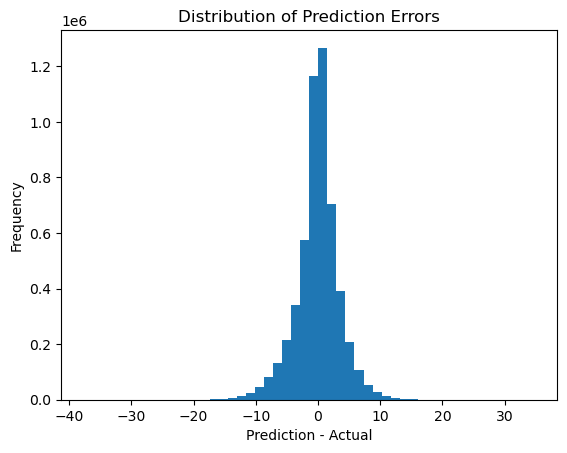

In [18]:
pdf = residuals.select("prediction", TARGET_COL, "error").toPandas()
plt.hist(pdf["error"], bins=50)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction - Actual")
plt.ylabel("Frequency")
plt.show()

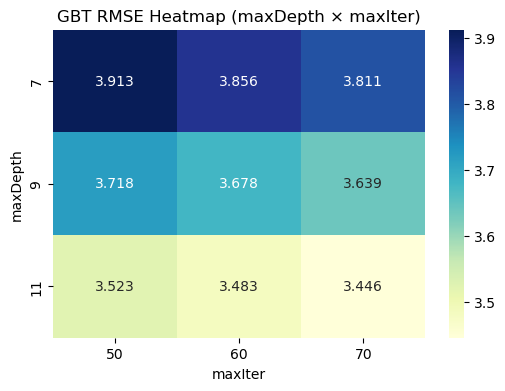

In [21]:
metrics = tuned_model.validationMetrics
params = tuned_model.getEstimatorParamMaps()

rows = []
for m, p in zip(metrics, params):
    rows.append({
        "rmse": m,
        "maxDepth": p[gbt.maxDepth],
        "maxIter": p[gbt.maxIter],
    })

df2 = pd.DataFrame(rows)

pivot = df2.pivot(index="maxDepth", columns="maxIter", values="rmse")
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("GBT RMSE Heatmap (maxDepth × maxIter)")
plt.ylabel("maxDepth")
plt.xlabel("maxIter")
plt.show()

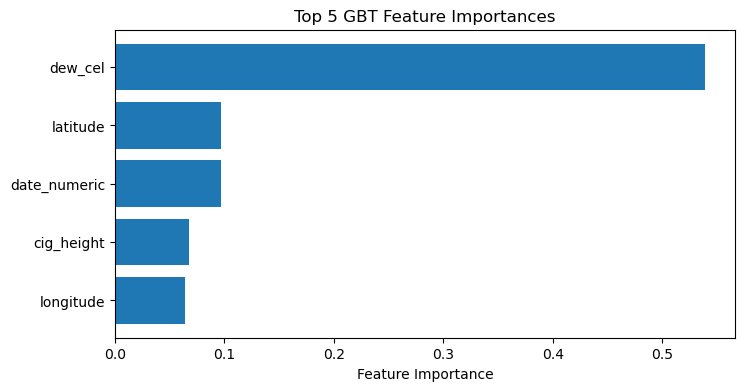

In [20]:
# Extract feature importances
importances = best_model.stages[-1].featureImportances.toArray()

feat_df = pd.DataFrame({
    "feature": FEATURE_COLS,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot top 5
plt.figure(figsize=(8,4))
plt.barh(feat_df["feature"].head(5), feat_df["importance"].head(5))
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 5 GBT Feature Importances")
plt.show()

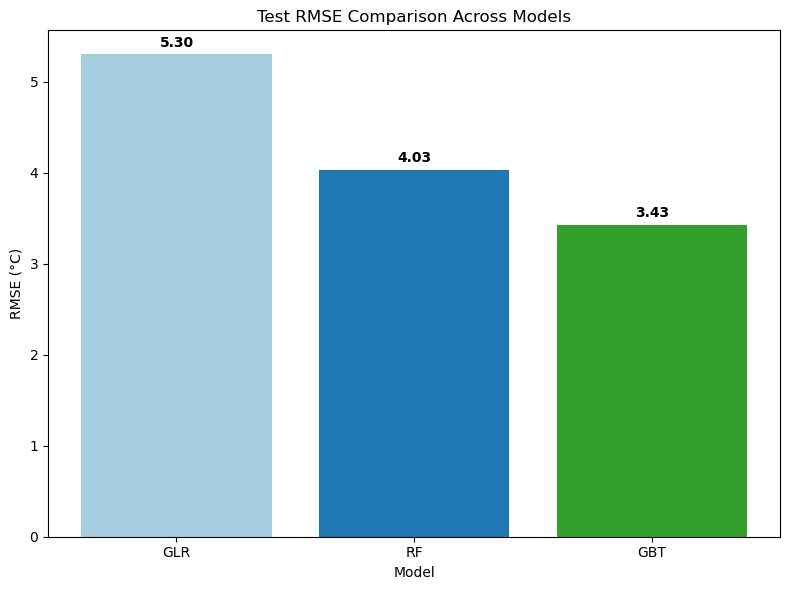

In [27]:
# Final Comparison of different Models

# Data - to update the rmse values based on the results of all 3 models
models = ['GLR', 'RF', 'GBT']
rmse = [5.30, 4.03, 3.43]

# Plot
plt.figure(figsize=(8,6))
bars = plt.bar(models, rmse, color=['#a6cee3', '#1f78b4', '#33a02c'])
plt.title('Test RMSE Comparison Across Models')
plt.ylabel('RMSE (°C)')
plt.xlabel('Model')

# Add RMSE labels above bars
for bar, value in zip(bars, rmse):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.05, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()